# Meta_Abd Comparison

This notebook generates the results comparing NSIL to Meta_Abd:

* [Neural network accuracy](#nn_acc)
* [Task MAE/log MAE](#task_mae)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import json
import torch
import yaml
import math
import re
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from scipy.stats import sem
from os.path import join
from tqdm import tqdm

In [5]:
# Helper functions
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [6]:
def read_meta_abd(example_dir, dataset):
    if 'sum' in dataset:
        f_name = 'sum'
    else:
        f_name = 'prod'
    with open(join(example_dir, 'baselines', 'saved_results', 'Meta_Abd', f'meta_abd_{f_name}_initial_run.txt'), 'r') as mabd:
        mabd = mabd.read()
    ptn = r'Average\sloss:\s\d+.\d+.\sAccuracy:\s(\d+)'
    
    accs = [int(x)/10000 for x in re.findall(ptn, mabd)]
    return accs[:51]

In [13]:
def plot_acc(example_dir, 
             num_epochs=50, 
             datasets=['meta_abd_data_sum', 'meta_abd_data_prod'], 
             acc_type='network', 
             ylim=[-0.05, 1.05], 
             xlim=[-0.05, 101],
             save_legend=False):
    nsil_repeats_dir = join(example_dir, 'saved_results', 'repeats')
    figure_handles = []
    figure_labels = []
    fig = plt.figure("data figure")
    legend_fig = plt.figure("legend figure")
    ax = fig.add_subplot(111)

    colors = ['k','b']
    m_abd_colors = ['r','g']
    m_abd_lines = [':', '--']
    lines = ['-', '-.']
    for d_idx, dataset in enumerate(datasets):
        nsil_means = []
        nsil_errs = []
        nsil_dir = nsil_repeats_dir + '/' + dataset
        repeats = os.listdir(nsil_dir)
        repeats = [r for r in repeats if r != '.DS_Store']
        repeats.sort(key=natural_keys)

        # X data is just epoch number
        full_range = num_epochs + 1
        X = list(range(full_range))
        for epoch_num in range(full_range):
            all_results_epoch = []

            for idx, i in enumerate(repeats):
                with open(join(nsil_dir, i, 'test_log.json'), 'r') as jf:
                    tl = json.loads(jf.read())
                
                if str(epoch_num) not in tl:
                    print('Repeat not complete:')
                    print(join(nsil_dir, i, 'test_log.json'))
                    continue
                if acc_type == 'network_accuracy':
                    acc = tl[str(epoch_num)]['network_accuracy']['digit']
                else:
                    acc = tl[str(epoch_num)]['end_to_end_acc']
                
                all_results_epoch.append(acc)
            # Compute mean and std err across all repeats
            nsil_means.append(np.mean(all_results_epoch))
            nsil_errs.append(sem(all_results_epoch))
        
        # Plot graph
        if 'sum' in dataset:
            d_label = 'Addition'
        else:
            d_label = 'Product'
        nsl_plot, = ax.plot(X, nsil_means, color=colors[d_idx], linestyle=lines[d_idx], label=f'NSIL {d_label}')
        ax.errorbar(X, nsil_means, nsil_errs, color=colors[d_idx],linestyle=lines[d_idx], capsize=5)
        figure_handles.append(nsl_plot)
        figure_labels.append(f'NSIL {d_label}')
    
    for d_idx, dataset in enumerate(datasets):
        if 'sum' in dataset:
            d_label = 'Addition'
        else:
            d_label = 'Product'
        m_abd = read_meta_abd(example_dir, dataset)
        b_plot, = ax.plot(range(len(m_abd)), m_abd, color=m_abd_colors[d_idx], linestyle=m_abd_lines[d_idx], label=f'Meta_Abd {d_label}')
        figure_handles.append(b_plot)
        figure_labels.append(f'Meta_Abd {d_label}')
        
    ax.set_xlabel('Epoch', fontsize=12)
#     ax.set_xticks(X)
    if acc_type == 'network_accuracy':
        ax.set_ylabel('Network Accuracy', fontsize=12)
    else:
        ax.set_ylabel('Accuracy', fontsize=12)
    ax.grid(which='both')
#     ax.legend()
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    if save_legend:
        legend_fig.legend(figure_handles, figure_labels, loc='center', ncol=2)
        legend_fig.savefig('../figures/nsil_vs_meta_abd_legend.pdf', bbox_inches='tight')
    else:
        fig.savefig('../figures/nsil_vs_meta_abd.pdf', bbox_inches='tight')

In [8]:
def get_network_acc(example_dir, 
         num_epochs=50):
    
    nsil_repeats_dir = join(example_dir, 'saved_results', 'repeats')
    for d_idx, dataset in enumerate(['meta_abd_data_sum', 'meta_abd_data_prod']):
        nsil_accs = []
        max_acc = 0
        nsil_dir = nsil_repeats_dir + '/' + dataset
        repeats = os.listdir(nsil_dir)
        repeats = [r for r in repeats if r != '.DS_Store']
        repeats.sort(key=natural_keys)

        # X data is just epoch number
        full_range = num_epochs + 1
        X = list(range(full_range))

        for idx, i in enumerate(repeats):
            with open(join(nsil_dir, i, 'test_log.json'), 'r') as jf:
                tl = json.loads(jf.read())
            if str(num_epochs) not in tl:
                print('Repeat not complete:')
                print(join(nsil_dir, i, 'test_log.json'))
                continue
            acc = tl[str(num_epochs)]['network_accuracy']['digit']
            if acc > max_acc:
                max_acc = acc
            nsil_accs.append(acc)
        
        net_acc = np.mean(np.array(nsil_accs))
        net_err = sem(np.array(nsil_accs))
        print(f'Dataset: {dataset}, Avg network accuracy: {net_acc} ({net_err})')
        print(f'Dataset: {dataset}, Max network accuracy: {max_acc}')


<a id='nn_acc'></a>
# Network accuracy

In [9]:
example = '../../../examples/recursive_arithmetic'
get_network_acc(example)

Dataset: meta_abd_data_sum, Avg network accuracy: 0.98444 (0.00014696938456700017)
Dataset: meta_abd_data_sum, Max network accuracy: 0.9848
Dataset: meta_abd_data_prod, Avg network accuracy: 0.9828399999999998 (0.00022715633383202008)
Dataset: meta_abd_data_prod, Max network accuracy: 0.9835


In [14]:
%%capture
plot_acc(example, datasets=['meta_abd_data_sum', 'meta_abd_data_prod'], acc_type='network_accuracy', xlim=[-2, 52], save_legend=True)

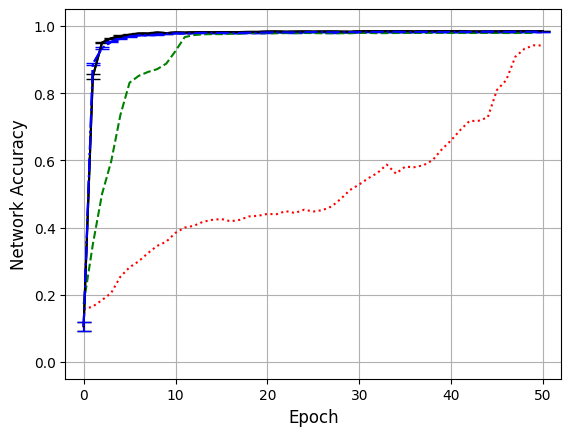

<Figure size 640x480 with 0 Axes>

In [12]:
plot_acc(example, datasets=['meta_abd_data_sum', 'meta_abd_data_prod'], acc_type='network_accuracy', xlim=[-2, 52])

<a id='task_mae'></a>
# Task MAE

In [24]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def conv_net(out_dim):
    return nn.Sequential(
        nn.Conv2d(1, 32, 3, 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        Flatten(),
        nn.Linear(9216, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, out_dim),
        nn.Softmax(dim=1)
    )


class Net(nn.Module):
    def __init__(self, out_dim):
        super(Net, self).__init__()
        self.enc = conv_net(out_dim)

    def forward(self, x):
        return self.enc(x)


In [25]:
MNIST_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
MNIST_TEST = DataLoader(MNIST(root='../../../data', train=False, download=False, transform=MNIST_transform), batch_size=64)

In [26]:
def get_nn_preds(_net, _loader):
    with torch.no_grad():
        all_preds = torch.tensor([], device='cpu')
        for data, targets in _loader:
            outputs = _net(data)
            confs, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.to('cpu')), 0)
        return all_preds


In [27]:
# For each repeat, at epoch 10, load network, get test predictions, compute MAE
def task_results(example, data_files):
    
    for dataset in data_files:        
        nsil_dir = join(example, 'saved_results', 'repeats', dataset)
        repeats = os.listdir(nsil_dir)
        repeats = [r for r in repeats if r != '.DS_Store']
        repeats.sort(key=natural_keys)
        
        for test_file in data_files[dataset]:
            with open(join(example, 'data', test_file), 'r') as f:
                TASK_DATA = yaml.load(f, Loader=yaml.Loader)
        
            results = []
            for idx, i in enumerate(repeats):
                try:
                    net_weights_file = join(nsil_dir, i, 'networks', 'net_digit_iteration_50.pt')
                    net = Net(10)
                    net.load_state_dict(torch.load(net_weights_file, map_location=torch.device('cpu')))
                    net.eval()
                except:
                    print(f"Skipping repeat {i} as no iteration 10 network...")
                    continue

                # Get network predictions on test images
                nn_preds = get_nn_preds(net, MNIST_TEST)

                # For each example in test set, compute metrics
                task_preds = []
                task_targets = []
                for ex in TASK_DATA:
                    ex_preds = [int(nn_preds[x].item()) for x in ex.x_idxs]
                    if 'sum' in dataset:
                        task_pred = sum(ex_preds)
                    else:
                        task_pred = np.prod(np.array(ex_preds))
                    task_preds.append(task_pred)
                    task_targets.append(ex.y)
                
                    
                # Compute MAE or logMAE
                if 'sum' in dataset:
                    test_loss = torch.nn.L1Loss(reduction='sum')(
                        torch.FloatTensor(task_preds), torch.FloatTensor(task_targets)).item()
                else:
                    test_loss = torch.nn.L1Loss(reduction='sum')(
                        torch.log(torch.FloatTensor(task_preds)+1e-10),
                        torch.log(torch.FloatTensor(task_targets)+1e-10)).item()
                test_loss /= len(TASK_DATA)
                results.append(test_loss)
            
            # Compute average over repeats
            avg = np.mean(np.array(results))
            if 'prod' in dataset:
                mae_type = 'logMAE'
            else:
                mae_type = 'MAE'
            print(f'File: {test_file}, {mae_type}: {avg:f}')
            
                    
            
        
        

In [28]:
d_fs = {
    'meta_abd_data_sum': ['mysum_full_test.yaml', 'mysum_full_test_10.yaml', 'mysum_full_test_100.yaml'],
    'meta_abd_data_prod': ['myprod_full_test.yaml', 'myprod_full_test_10.yaml', 'myprod_full_test_15.yaml']
}

In [29]:
task_results(example, d_fs)

File: mysum_full_test.yaml, MAE: 0.207920
File: mysum_full_test_10.yaml, MAE: 0.550420
File: mysum_full_test_100.yaml, MAE: 3.959680
File: myprod_full_test.yaml, logMAE: 0.290473
File: myprod_full_test_10.yaml, logMAE: 0.468566
File: myprod_full_test_15.yaml, logMAE: 2.097720
